In [33]:
# !pip install nltk
# !pip install gensim
# !pip install matplotlib
import pandas as pd
import nltk
import re
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt




In [34]:
def simple_tokenize(text):
    """
    Tokenizer 
    """
    tokens = nltk.word_tokenize(text)
    tokens = [t.lower() for t in tokens if re.match(r"^[a-zA-Z]+$", t)]
    return tokens


def build_tagged_documents(df, text_col="transcript", id_cols=("Participant")):
    """
    Convert rows of a DataFrame into TaggedDocument objects for Doc2Vec.
    """
    tagged_docs = []
    for idx, row in df.iterrows():
        text = str(row[text_col]) # get transcript and tokenize 
        tokens = simple_tokenize(text)
        
       
        if isinstance(id_cols, (list, tuple)):
            tag_list = []
            for c in id_cols:
                tag_list.append(str(row[c]))
            doc_tag = "_".join(tag_list)
        else:
            doc_tag = str(row[id_cols])  # if it's a single string
        
        tagged_docs.append(TaggedDocument(words=tokens, tags=[doc_tag]))
    return tagged_docs


In [ ]:
path = "/Users/minghill/Desktop/BU/TalentTora/talentora-analysisbot/test/doc2vec/data/merged_id_scores_medium.csv"

df = pd.read_csv(path)

nltk.download('punkt_tab')

tagged_docs = build_tagged_documents(df)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/minghill/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [36]:
print(tagged_docs)

[TaggedDocument(words=['so', 'how', 'are', 'you', 'doing', 'today', 'pretty', 'well', 'good', 'good', 'tell', 'me', 'about', 'yourself', 'i', 'mickey', 'i', 'am', 'a', 'course', 'majoring', 'in', 'mit', 'and', 'junior', 'this', 'year', 'i', 'live', 'in', 'east', 'campus', 'i', 'think', 'i', 'was', 'a', 'bit', 'too', 'oh', 'great', 'i', 'from', 'minnesota', 'tell', 'me', 'about', 'a', 'time', 'you', 'demonstrated', 'leadership', 'i', 'was', 'in', 'apm', 'i', 'was', 'the', 'fellowship', 'as', 'personal', 'project', 'okay', 'which', 'one', 'of', 'those', 'was', 'responsible', 'for', 'organizing', 'a', 'previous', 'program', 'basically', 'it', 'split', 'into', 'three', 'sections', 'okay', 'so', 'it', 'was', 'organizing', 'events', 'that', 'helped', 'foster', 'friendship', 'among', 'those', 'three', 'okay', 'so', 'tell', 'me', 'about', 'a', 'time', 'you', 'were', 'working', 'in', 'a', 'team', 'and', 'faced', 'a', 'challenge', 'how', 'did', 'you', 'solve', 'that', 'problem', 'so', 'we', 'had

In [37]:
print(len(tagged_docs))

77


In [43]:
def train_doc2vec_model(tagged_docs, vector_size=50, window=5, min_count=2, epochs=20, dm=1):
    print(f"Training Doc2Vec model with vector_size={vector_size}, window={window}, min_count={min_count}, epochs={epochs}, dm={dm}")
    model = Doc2Vec(
        documents=tagged_docs,
        vector_size=vector_size,
        window=window,
        min_count=min_count,
        dm=dm
    )
    print(f"Starting training on {model.corpus_count} documents...")
    model.train(tagged_docs, total_examples=model.corpus_count, epochs=epochs)
    print(f"Doc2Vec model training completed after {epochs} epochs")
    return model


def doc2vec_inference(df, model, text_col="transcript"):
    print(f"Inferring Doc2Vec vectors for {len(df)} documents...")
    vectors = []
    for idx, row in df.iterrows():
        if idx % 100 == 0 and idx > 0: 
            print(f"Processed {idx}/{len(df)} documents")
        tokens = simple_tokenize(row[text_col])
        vec = model.infer_vector(tokens)
        vectors.append(vec)
    
    vec_array = np.array(vectors)
    for dim in range(vec_array.shape[1]):
        df[f"d2v_{dim}"] = vec_array[:, dim]
    return df


def train_and_evaluate_regression(df, target_col="Overall", embed_prefix="d2v_"):
    feature_cols = [c for c in df.columns if c.startswith(embed_prefix)]
    print(f"Using {len(feature_cols)} features for regression on target '{target_col}'")
    
    df = df.dropna(subset=[target_col])
    print(f"Training on {len(df)} samples after removing NaN values")
    
    X = df[feature_cols] #.values
    y = df[target_col] #.values

    print("\nDoc2Vec columns used for training:")
    for i, col in enumerate(X.columns):
        print(f"{i+1}. {col}")
    print(f"\nTotal doc2vec features: {len(X.columns)}")

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"Split data into train ({len(X_train)} samples) and test ({len(X_test)} samples)")
    
    print("Training Ridge regression model...")
    reg = Ridge(alpha=1.0)
    reg.fit(X_train, y_train)
    
    print("Evaluating model on test data...")
    y_pred = reg.predict(X_test)
    
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    print(f"{target_col} -- R^2: {r2:.3f}, MSE: {mse:.3f}")
    
    # Visualize results
    plt.figure(figsize=(12, 8))
    
    # Plot 1: Actual vs Predicted values
    plt.subplot(2, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title(f'Actual vs Predicted {target_col}')
    
    # Plot 2: Residuals
    plt.subplot(2, 2, 2)
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residual Plot')
    
    # Plot 3: Distribution of residuals
    plt.subplot(2, 2, 3)
    plt.hist(residuals, bins=20, alpha=0.7)
    plt.xlabel('Residual Value')
    plt.ylabel('Frequency')
    plt.title('Residual Distribution')
    
    # Plot 4: Feature importance (top 10)
    plt.subplot(2, 2, 4)
    importance = np.abs(reg.coef_)
    indices = np.argsort(importance)[::-1][:10]  # Top 10 features
    plt.bar(range(10), importance[indices])
    plt.xticks(range(10), [f"Feature {i}" for i in indices], rotation=45)
    plt.xlabel('Feature')
    plt.ylabel('Importance')
    plt.title('Top 10 Feature Importance')
    
    plt.tight_layout()
    plt.suptitle(f'Regression Analysis for {target_col}', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()
    
    return reg

Training Doc2Vec model with vector_size=50, window=5, min_count=2, epochs=20, dm=1
Starting training on 77 documents...
Doc2Vec model training completed after 20 epochs
Inferring Doc2Vec vectors for 77 documents...
Using 50 features for regression on target 'Overall'
Training on 77 samples after removing NaN values

Doc2Vec columns used for training:
1. d2v_0
2. d2v_1
3. d2v_2
4. d2v_3
5. d2v_4
6. d2v_5
7. d2v_6
8. d2v_7
9. d2v_8
10. d2v_9
11. d2v_10
12. d2v_11
13. d2v_12
14. d2v_13
15. d2v_14
16. d2v_15
17. d2v_16
18. d2v_17
19. d2v_18
20. d2v_19
21. d2v_20
22. d2v_21
23. d2v_22
24. d2v_23
25. d2v_24
26. d2v_25
27. d2v_26
28. d2v_27
29. d2v_28
30. d2v_29
31. d2v_30
32. d2v_31
33. d2v_32
34. d2v_33
35. d2v_34
36. d2v_35
37. d2v_36
38. d2v_37
39. d2v_38
40. d2v_39
41. d2v_40
42. d2v_41
43. d2v_42
44. d2v_43
45. d2v_44
46. d2v_45
47. d2v_46
48. d2v_47
49. d2v_48
50. d2v_49

Total doc2vec features: 50
Split data into train (61 samples) and test (16 samples)
Training Ridge regression model

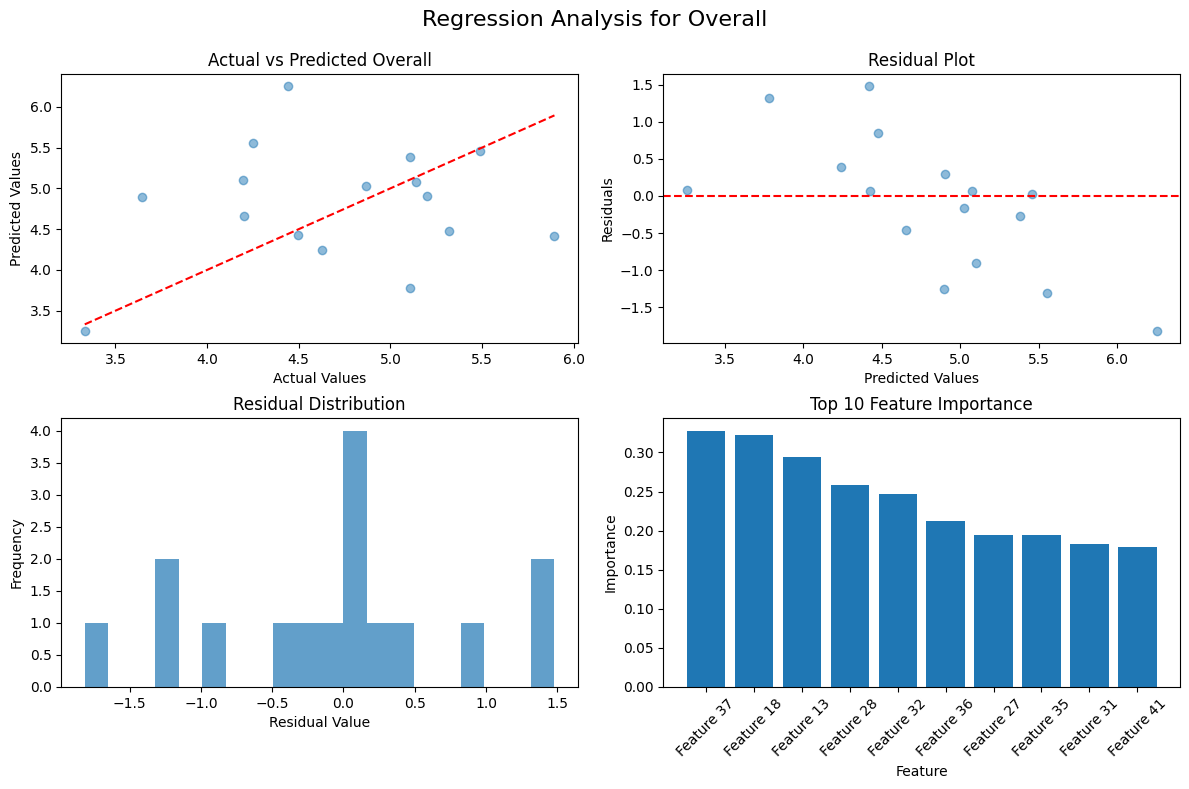

In [ ]:
d2v_model = train_doc2vec_model(tagged_docs, vector_size=50, epochs=20)

'''Final DF would be merged_id_scores'''
path = "/Users/minghill/Desktop/BU/TalentTora/talentora-analysisbot/test/doc2vec/data/merged_id_scores_medium.csv"
final_df = pd.read_csv(path)
final_df = doc2vec_inference(final_df, d2v_model)

reg_model = train_and_evaluate_regression(final_df, target_col="Overall")



## v2

2025-02-25 23:53:42,549 - INFO - Starting model comparison for RecommendHiring using doc2vec features
2025-02-25 23:53:42,550 - INFO - Starting doc2vec regression model comparison for target: RecommendHiring
2025-02-25 23:53:42,555 - INFO - Data prepared: X shape=(77, 50), y shape=(77,)
2025-02-25 23:53:42,557 - INFO - Data split: train=61 samples, test=16 samples
2025-02-25 23:53:42,557 - INFO - Defined 6 regression models for comparison
2025-02-25 23:53:42,558 - INFO - Training Linear Regression...
2025-02-25 23:53:42,585 - INFO - Linear Regression best parameters: {'fit_intercept': True}
2025-02-25 23:53:42,591 - INFO - Making predictions with best Linear Regression model...
2025-02-25 23:53:42,594 - INFO - Linear Regression performance - MSE: 4.0657, RMSE: 2.0164, MAE: 1.6309, R²: -6.0690
2025-02-25 23:53:42,594 - INFO - Training Ridge Regression...


Found 50 doc2vec columns in the dataset

Doc2Vec columns used for training:
1. d2v_0
2. d2v_1
3. d2v_2
4. d2v_3
5. d2v_4
6. d2v_5
7. d2v_6
8. d2v_7
9. d2v_8
10. d2v_9
11. d2v_10
12. d2v_11
13. d2v_12
14. d2v_13
15. d2v_14
16. d2v_15
17. d2v_16
18. d2v_17
19. d2v_18
20. d2v_19
21. d2v_20
22. d2v_21
23. d2v_22
24. d2v_23
25. d2v_24
26. d2v_25
27. d2v_26
28. d2v_27
29. d2v_28
30. d2v_29
31. d2v_30
32. d2v_31
33. d2v_32
34. d2v_33
35. d2v_34
36. d2v_35
37. d2v_36
38. d2v_37
39. d2v_38
40. d2v_39
41. d2v_40
42. d2v_41
43. d2v_42
44. d2v_43
45. d2v_44
46. d2v_45
47. d2v_46
48. d2v_47
49. d2v_48
50. d2v_49

Total doc2vec features: 50


2025-02-25 23:53:42,970 - INFO - Ridge Regression best parameters: {'alpha': 10.0, 'solver': 'auto'}
2025-02-25 23:53:42,973 - INFO - Making predictions with best Ridge Regression model...
2025-02-25 23:53:42,976 - INFO - Ridge Regression performance - MSE: 0.6318, RMSE: 0.7949, MAE: 0.6173, R²: -0.0985
2025-02-25 23:53:42,977 - INFO - Training Lasso Regression...
2025-02-25 23:53:43,097 - INFO - Lasso Regression best parameters: {'alpha': 0.1, 'max_iter': 1000}
2025-02-25 23:53:43,116 - INFO - Making predictions with best Lasso Regression model...
2025-02-25 23:53:43,119 - INFO - Lasso Regression performance - MSE: 0.5931, RMSE: 0.7702, MAE: 0.5661, R²: -0.0313
2025-02-25 23:53:43,120 - INFO - Training ElasticNet...
2025-02-25 23:53:43,236 - INFO - ElasticNet best parameters: {'alpha': 0.1, 'l1_ratio': 0.7}
2025-02-25 23:53:43,237 - INFO - Making predictions with best ElasticNet model...
2025-02-25 23:53:43,238 - INFO - ElasticNet performance - MSE: 0.6027, RMSE: 0.7763, MAE: 0.5892, 


Doc2Vec Model Comparison Results:
               Model       MSE      RMSE       MAE        R²
0  Linear Regression  4.065668  2.016350  1.630894 -6.069039
1   Ridge Regression  0.631808  0.794864  0.617290 -0.098535
2   Lasso Regression  0.593142  0.770157  0.566110 -0.031306
3         ElasticNet  0.602718  0.776349  0.589151 -0.047955
4      Random Forest  0.612517  0.782635  0.586036 -0.064993
5                SVM  0.685103  0.827710  0.678990 -0.191199


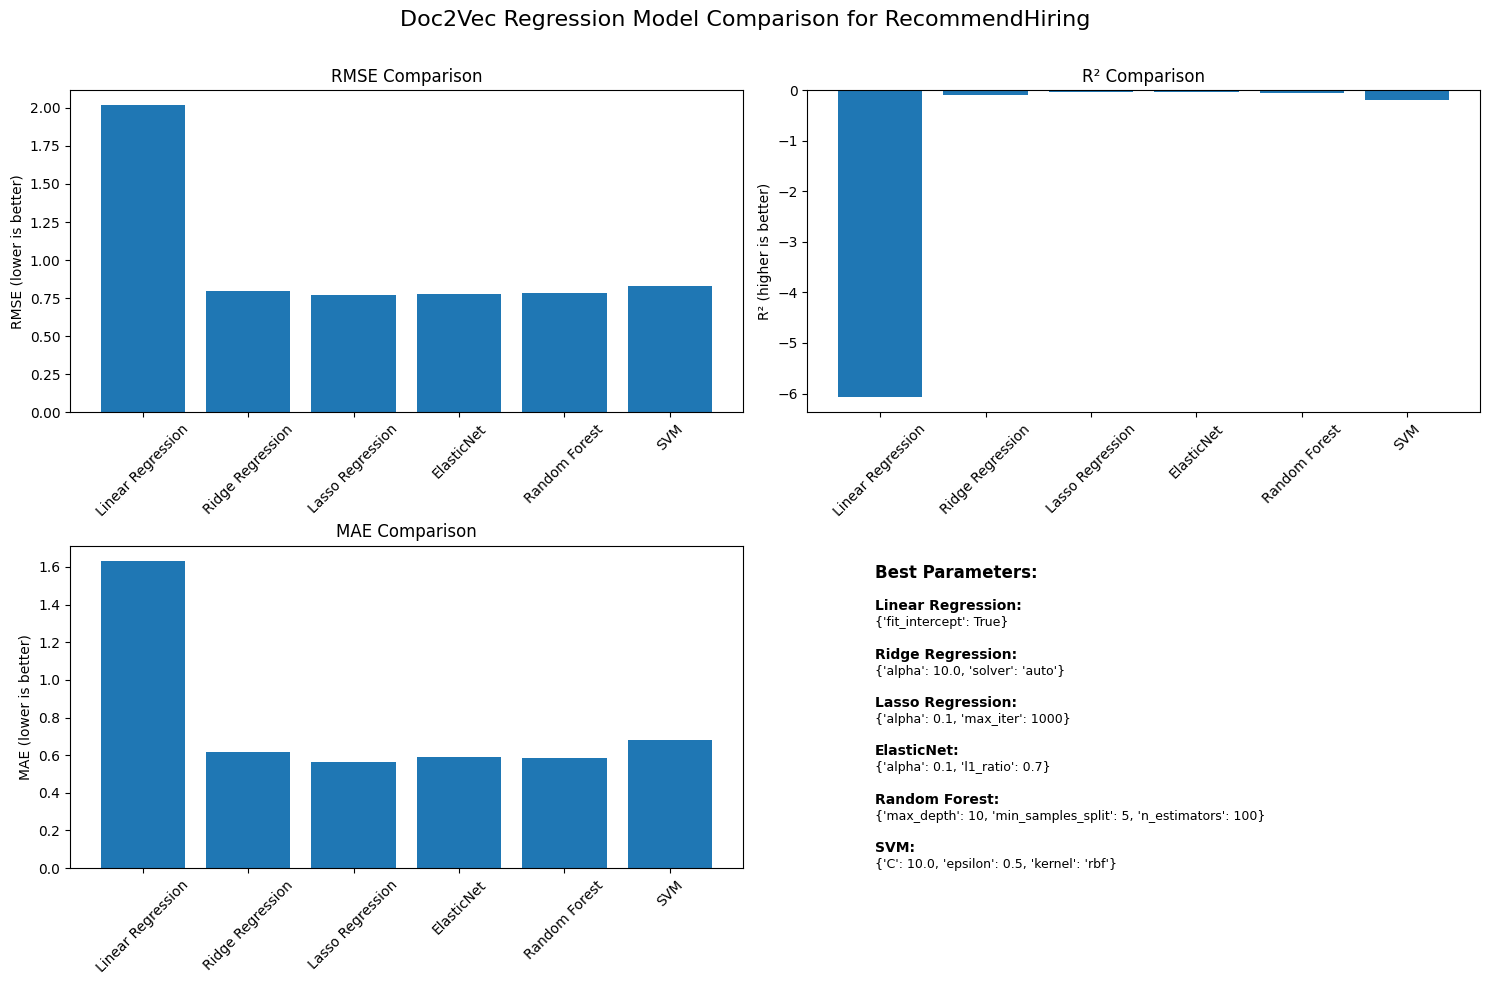

2025-02-25 23:53:47,294 - INFO - Best model based on R²: Lasso Regression
2025-02-25 23:53:47,295 - INFO - Doc2Vec model comparison completed



Best model based on R²: Lasso Regression


In [46]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import logging

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

def prepare_data_doc2vec(df, target_col):
    """Prepare data for regression modeling using only doc2vec features."""
    # Make a copy to avoid modifying the original dataframe
    df_copy = df.copy()
    
    # Extract only doc2vec columns (they start with 'd2v_')
    doc2vec_cols = [col for col in df_copy.columns if col.startswith('d2v_')]
    
    if not doc2vec_cols:
        logger.error("No doc2vec columns found in the dataframe")
        raise ValueError("No doc2vec columns found. Ensure doc2vec features are prefixed with 'd2v_'")
    
    # Use only doc2vec columns as features
    X = df_copy[doc2vec_cols]
    y = df_copy[target_col]
    
    # Print doc2vec columns being used for training
    print("\nDoc2Vec columns used for training:")
    for i, col in enumerate(X.columns):
        print(f"{i+1}. {col}")
    print(f"\nTotal doc2vec features: {len(X.columns)}")
    
    logger.info(f"Data prepared: X shape={X.shape}, y shape={y.shape}")
    
    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    logger.info(f"Data split: train={X_train.shape[0]} samples, test={X_test.shape[0]} samples")
    
    return X_train, X_test, y_train, y_test

def define_models():
    """Define regression models and their hyperparameters."""
    models = {
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {
                'fit_intercept': [True, False]
            }
        },
        'Ridge Regression': {
            'model': Ridge(),
            'params': {
                'alpha': [0.1, 1.0, 10.0],
                'solver': ['auto', 'svd', 'cholesky']
            }
        },
        'Lasso Regression': {
            'model': Lasso(),
            'params': {
                'alpha': [0.01, 0.1, 1.0],
                'max_iter': [1000, 2000]
            }
        },
        'ElasticNet': {
            'model': ElasticNet(),
            'params': {
                'alpha': [0.1, 1.0],
                'l1_ratio': [0.3, 0.5, 0.7]
            }
        },
        'Random Forest': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [50, 100],
                'max_depth': [None, 10, 20],
                'min_samples_split': [2, 5]
            }
        },
        'SVM': {
            'model': SVR(),
            'params': {
                'kernel': ['linear', 'rbf'],
                'C': [0.1, 1.0, 10.0],
                'epsilon': [0.1, 0.2, 0.5]
            }
        }
    }
    
    logger.info(f"Defined {len(models)} regression models for comparison")
    return models

def train_and_evaluate_model(model_name, model_info, X_train, X_test, y_train, y_test):
    """Train and evaluate a single model."""
    logger.info(f"Training {model_name}...")
    
    try:
        # Create and fit GridSearchCV
        grid_search = GridSearchCV(model_info['model'], model_info['params'], cv=5, scoring='r2', error_score='raise')
        grid_search.fit(X_train, y_train)
        
        # Get the best model
        best_model = grid_search.best_estimator_
        logger.info(f"{model_name} best parameters: {grid_search.best_params_}")
        
        # Make predictions
        logger.info(f"Making predictions with best {model_name} model...")
        y_pred = best_model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, y_pred)
        rmse = np.sqrt(mse)
        mae = mean_absolute_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        logger.info(f"{model_name} performance - MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
        
        # Return results
        return {
            'Model': model_name,
            'Best Parameters': grid_search.best_params_,
            'MSE': mse,
            'RMSE': rmse,
            'MAE': mae,
            'R²': r2,
            'Best Model': best_model
        }
    except Exception as e:
        logger.error(f"Error training {model_name}: {str(e)}")
        return None

def plot_model_comparison(results_df, target_col):
    """Generate plots comparing model performance."""
    logger.info("Generating comparison plots...")
    plt.figure(figsize=(15, 10))
    
    # Plot 1: RMSE Comparison
    plt.subplot(2, 2, 1)
    plt.bar(results_df['Model'], results_df['RMSE'])
    plt.xticks(rotation=45)
    plt.title('RMSE Comparison')
    plt.ylabel('RMSE (lower is better)')
    
    # Plot 2: R² Comparison
    plt.subplot(2, 2, 2)
    plt.bar(results_df['Model'], results_df['R²'])
    plt.xticks(rotation=45)
    plt.title('R² Comparison')
    plt.ylabel('R² (higher is better)')
    
    # Plot 3: MAE Comparison
    plt.subplot(2, 2, 3)
    plt.bar(results_df['Model'], results_df['MAE'])
    plt.xticks(rotation=45)
    plt.title('MAE Comparison')
    plt.ylabel('MAE (lower is better)')
    
    # Plot 4: Best parameters
    plt.subplot(2, 2, 4)
    plt.axis('off')
    plt.text(0.1, 0.9, "Best Parameters:", fontsize=12, fontweight='bold')
    y_pos = 0.8
    for model_name, params in results_df[['Model', 'Best Parameters']].values:
        plt.text(0.1, y_pos, f"{model_name}:", fontsize=10, fontweight='bold')
        plt.text(0.1, y_pos-0.05, f"{params}", fontsize=9)
        y_pos -= 0.15
    
    plt.tight_layout()
    plt.suptitle(f'Doc2Vec Regression Model Comparison for {target_col}', fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()

def compare_doc2vec_regression_models(df, target_col="RecommendHiring"):
    """Compare multiple regression models using only doc2vec features."""
    logger.info(f"Starting doc2vec regression model comparison for target: {target_col}")
    
    # Prepare the data using only doc2vec features
    X_train, X_test, y_train, y_test = prepare_data_doc2vec(df, target_col)
    
    # Define models and their hyperparameters
    models = define_models()
    
    # Train and evaluate each model
    results = []
    best_models = {}
    
    for model_name, model_info in models.items():
        model_result = train_and_evaluate_model(model_name, model_info, X_train, X_test, y_train, y_test)
        if model_result:
            results.append({k: v for k, v in model_result.items() if k != 'Best Model'})
            best_models[model_name] = model_result['Best Model']
    
    if not results:
        logger.error("No models were successfully trained")
        return None
    
    # Convert results to DataFrame
    results_df = pd.DataFrame(results)
    
    # Display results
    logger.info("Model comparison completed")
    print("\nDoc2Vec Model Comparison Results:")
    print(results_df[['Model', 'MSE', 'RMSE', 'MAE', 'R²']])
    
    # Plot comparison
    plot_model_comparison(results_df, target_col)
    
    # Return the best model based on R²
    best_model_name = results_df.loc[results_df['R²'].idxmax(), 'Model']
    logger.info(f"Best model based on R²: {best_model_name}")
    print(f"\nBest model based on R²: {best_model_name}")
    return best_models[best_model_name]

# Compare different regression models for RecommendHiring using only doc2vec features
logger.info("Starting model comparison for RecommendHiring using doc2vec features")
try:
    # Check for doc2vec columns in the dataframe
    doc2vec_cols = [col for col in final_df.columns if col.startswith('d2v_')]
    print(f"Found {len(doc2vec_cols)} doc2vec columns in the dataset")
    
    if len(doc2vec_cols) == 0:
        print("Warning: No doc2vec columns found. Make sure doc2vec features are prefixed with 'd2v_'")
    
    
    best_model = compare_doc2vec_regression_models(final_df, target_col="RecommendHiring")
    logger.info("Doc2Vec model comparison completed")
except Exception as e:
    logger.error(f"Error in model comparison: {str(e)}")
    print(f"Error: {str(e)}")